# Read/process relevant IR images
- Initial attempt at reading IR camera dataset
- Make movie of the IR images
- Includes histogram of IR images, showing double gaussian

In [1]:
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
import kray
# OS interaction
import sys, pickle, os
# import subplots function for plotting
import seaborn as sns
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import kgraph
import matplotlib.gridspec as gridspec
from moviepy.editor import *

# --------------------------------------------------------------------------------------------
# Directory Lists
# Unix
if 'linux' in sys.platform:
    dirPre = '/home/lapok/gdrive/'
# Mac
elif 'darwin' in sys.platform:
    dirPre = '/Users/karllapo/gdrive/'
# Directory for printing figures
dirPrint = dirPre + 'SnowHydrology/proj/TurbulenceFeedbacks/Graphics/IR_SnoqualmieFlights'
# Met data directory
dirData = dirPre + 'SnowHydrology/proj/TurbulenceFeedbacks/data/SNQ/IR_SnoqualmieFlights'

# --------------------------------------------------------------------------------------------
# Global formatting
sns.set_context('paper')
sns.set_style('whitegrid')
# must insert this statement to render the plots within the notebook
%matplotlib inline

In [2]:
# --------------------------------------------------------------------------------------------
# Functions/classes for reading binary files in python
# From: http://code.activestate.com/recipes/577610-decoding-binary-files/
import struct

class BinaryReaderEOFException(Exception):
    def __init__(self):
        pass
    def __str__(self):
        return 'Not enough bytes in file to satisfy read request'

class BinaryReader:
    # Map well-known type names into struct format characters.
    typeNames = {
        'int8'   :'b',
        'uint8'  :'B',
        'int16'  :'h',
        'uint16' :'H',
        'int32'  :'i',
        'uint32' :'I',
        'int64'  :'q',
        'uint64' :'Q',
        'float'  :'f',
        'double' :'d',
        'char'   :'s'}

    def __init__(self, fileName):
        self.file = open(fileName, 'rb')
        
    def seek(self, seekLocation):
        self.file.seek(seekLocation)

    def read(self, typeName):
        typeFormat = BinaryReader.typeNames[typeName.lower()]
        typeSize = struct.calcsize(typeFormat)
        value = self.file.read(typeSize)
        if typeSize != len(value):
            raise BinaryReaderEOFException
        return struct.unpack(typeFormat, value)[0]

    def __del__(self):
        self.file.close()

In [56]:
os.chdir(dirData)
fname = '1368575242_2013MAY14_2347CUT_PLANE_DRS-IR_0_STACK.dat'
# fname = '1368566727_2013MAY14_2125CUT_PLANE_DRS-IR_02_STACK.dat'

#  $eplace these with the appropriate paths and filenames
# I'm not clear on what each file actually is at the moment
# fn1 = '1368575242_2013MAY14_2347CUT_PLANE_DRS-IR_1_STACK.dat'
# fn0 = '1368575242_2013MAY14_2347CUT_PLANE_DRS-IR_0_STACK.dat'
# fnP = '1368575242_2013MAY14_2347CUT_PLANE-INS.DAT'
# fnE = '1368575246_2013MAY14_2347CUT_PLANE_DRS-IR_02_STACK.dat'

In [57]:
# --------------------------------------------------------------------------------------------
# Variables to pass to the read function:
# params - [bit_header_offset bit_spacer bit_depth width height]
# findex - specific frames to read in
# infoOnlyFlag - if True only return info on IR images
params = np.array([1904, 1904, 16, 640, 480])
# paramsE = [0 0 8 1280 960];  % parameter for reading in the EO images

# Converting camera data to brightness temperature:
# 

# fIndex = np.arange(0, 2000, 5)
fIndex = np.arange(3890, 6500, 10)
fIndex = np.atleast_1d(fIndex)
infoOnlyFlag = False

# get params for reading in and making data output
info = {}
info['hbit'] = params[0]
info['obit'] = params[1]
info['bit'] = params[2]
info['bitdepth'] = info['bit']
info['width'] = params[3]
info['height'] = params[4]

## Read IR Function

In [59]:
# --------------------------------------------------------------------------------------------
# Image information
fInfo = os.stat(fname)

# calculated frame number
nFrames = round((fInfo.st_size - (info['hbit'] -info['obit'])/8)
                /((info['width'] * info['height'] * info['bitdepth'] + info['obit']) / 8)) 
info['nframes'] = nFrames

# --------------------------------------------------------------------------------------------
# read time and temp from timesFile
# Time files have the same file name as the corresponding '*.dat' files
timeFilename = fname.split('.')[0]
timeFilename = timeFilename + '.txt'

# Check to see that the time file exists (nothing here yet)
# I think the best solution here is to throw an error if no file is found.
# The pandas 'read_csv' (below) should already give us this desired behavior

# Read the file with time stamps and camera temperatures for each image
timeFile = pd.read_csv(timeFilename,
                       header=None,
                       names=['epochTime',
                              'weirdRepeatedLine1', 'probeTemp1',
                              'weirdRepeatedLine2', 'probeTemp2'], 
                       index_col='epochTime')

# Assumes we are reading a csv with this form:
# 5 columnes: 1 time stamp, 4 giving camera temperatures (label1, temp1, label2, temp2)
# "1368578461.593, 280F9A5403000002 , 8.63 , 287FE81C040000F2 , 9.19"
# OR
# 1 column: time stamp
# "1368578461.593"
#
# Something about the temp probes was changed after April 2013 resulting in two different code
# blocks to handle each in the original matlab code. Since all of the data I'm using is after
# that date, I am going to ignore the code for data prior to that date

# exit on infoFlag
# if infoOnlyFlag:
#     return(info, probeTemp, timeFile)

# Each time stamp corresponds to an IR image.
numImages = timeFile.index.size
# Convert to numpy64 datetime objects (epochTime is in seconds since 1970)
timeFile.index = [datetime.fromtimestamp(d) for d in timeFile.index.values]

# Passing to output DataFrame
probeTemp = pd.DataFrame()
if timeFile.columns.size > 1 and timeFile.columns.size == 4:
    probeTemp['camTemp'] = timeFile.probeTemp1
    probeTemp['refTemp'] = timeFile.probeTemp2
elif timeFile.columns.size == 1:
    probeTemp = timeFile.index

# --------------------------------------------------------------------------------------------
# Acquire IR camera images
numFrames = fIndex.size
info['nFrames'] = numFrames

# There is this 'uvs' argument in the original matlab read script, but it isn't defined. This
# variable is never used in the 'snowIR_example.m' script, so I'm going to ignore the code block
# that handles it.
binDataOut = np.zeros([info['height'], info['width'], info['nFrames']])
imageSize = info['width'] * info['height']
nandex = []

for j in np.arange(0, numFrames):
    # Update progress
    if numFrames > 1:
        print("\r", '%d of %d' % (j + 1, numFrames), end="")

    # Discover next position in binary file
    seekBitLoc = (info['width'] * info['height'] * (info['bit'] / 8) + info['obit'] / 8) \
                 * (fIndex[j]) + info['hbit'] / 8
    seekBitLoc = int(seekBitLoc)

    # Ready binary file
    binaryReader = BinaryReader(fname)
    # Point python to the desired location in the binary file (0 means seek from beginning of file)
    binaryReader.seek(seekBitLoc)
    try:
        numBinaryItems = imageSize
        data = np.empty(numBinaryItems)
        for binIndex in np.arange(numBinaryItems):
            data[binIndex] = binaryReader.read('uint16')
        if np.std(data.flatten()/ 250 + 194) < 2:
            nandex = np.append(nandex, j)
            binDataOut[:, :, j] = data.reshape(info['height'], info['width']) * np.nan
        else:
            binDataOut[:, :, j] = data.reshape(info['height'], info['width'])

    except BinaryReaderEOFException:
        # One of our attempts to read a field went beyond the end of the file.
        print("Error: File seems to be corrupted.")


 261 of 261

In [123]:
for j in np.arange(numFrames):
    temp = binDataOut[:, :, j]
    if np.std(temp.flatten()/ 250 + 194) < 2:
        binDataOut[:, :, j] = np.ones((info['height'], info['width'])) * np.nan
    else:
        continue

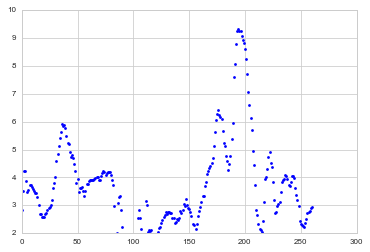

In [60]:
for j in np.arange(numFrames):
    plt.plot(j, np.std(binDataOut[:, :, j].flatten() / 250 + 194),'b.')

0.28194173516
[[ 281.408  281.52   281.04  ...,  280.352  280.272  280.368]
 [ 281.104  281.392  281.648 ...,  280.096  280.336  280.16 ]
 [ 281.296  281.2    281.184 ...,  280.528  280.208  280.56 ]
 ..., 
 [ 281.184  281.168  281.216 ...,  280.768  280.848  280.944]
 [ 280.896  281.344  281.232 ...,  280.88   281.04   281.168]
 [ 281.456  281.376  281.072 ...,  280.784  280.736  280.96 ]]


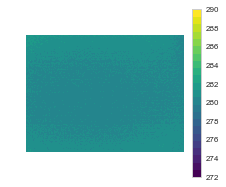

In [45]:
j = 109
fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
im = ax.imshow(binDataOut[:, :, j] / 250 + 194, interpolation='nearest',
               cmap=cmap, vmin=cmin, vmax=cmax)
ax.set_axis_off()
fig.colorbar(im)
print(np.std(binDataOut[:, :, j].flatten() / 250 + 194))
print(binDataOut[:, :, j] / 250 + 194)

## Convert to netCDF/xarray

In [124]:
finalData = np.ones_like(binDataOut)
for j in np.arange(numFrames):
    finalData[:, :, j] = (binDataOut[:, :, j] / 250 + 194)
mask = np.ones(numFrames, dtype=bool)
mask[[nandex.astype(int)]] = False
finalData = finalData[:, :, mask]
# brightTemp_Flight = xr.DataArray(binDataOut)


# Plot Images

In [10]:
# Fomatting options for images
cmin = 272
cmax = 290
tsp = np.linspace(cmin, cmax, 23)
cmap = kgraph.cmap_discretize(cm.viridis, 23)

os.chdir(dirPrint)

for j in np.arange(0, 5):#np.arange(numFrames):
    # Time stamp name for saved images
    timeStamp = str(timeFile.index[j].year) \
                + str(timeFile.index[j].month).zfill(2) \
                + str(timeFile.index[j].day).zfill(2) \
                + str(timeFile.index[j].hour*100) \
                + '_image' + str(fIndex[j])
    
    # IR image
    fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
    im = ax.imshow(binDataOut[:, :, j] / 250 + 194, interpolation='nearest',
                   cmap=cmap, vmin=cmin, vmax=cmax)
    ax.set_title(timeFile.index[j])
    ax.set_axis_off()
    fig.colorbar(im)
    fig.savefig(timeStamp + '.pdf')
    plt.close(fig)
    
    # Histogram of IR images
    fig, ax = plt.subplots(1, 1, figsize=(6.5, 2.5))
    ax.hist(binDataOut[:, :, j].reshape(info['height'] * info['width']) / 250 + 194,
            bins=np.arange(272, 290, .5));
    ax.set_title(timeFile.index[j])
    ax.set_ylim(0, 30000)
    ax.set_xlim(272, 290)
    ax.set_xlabel('$T_{bright}$')
    fig.autofmt_xdate()
    fig.savefig(timeStamp + '.hist.pdf')
    plt.close(fig)

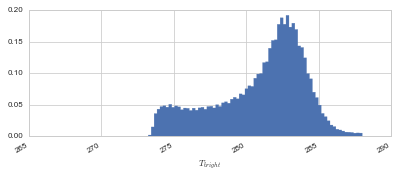

In [127]:
# Histogram of all IR images
fig, ax = plt.subplots(1, 1, figsize=(6.5, 2.5))
cspace = np.linspace(268, 288, 100)
ax.hist(finalData[:, :, 180:200].flatten(), bins=cspace, normed=True,
       fill=True, histtype='step')
# ax.set_xlim(-5, 15)
ax.set_xlabel('$T_{bright}$')
fig.autofmt_xdate()
fig.savefig('IR.AllImages.hist.pdf')

In [115]:
finalData.shape

(480, 640, 238)

# Movie

In [ ]:
## Read pngs, assign each one to a movie frame
os.chdir(dirPrint)

# List of April images
content = os.listdir(os.getcwd())
clip_dict = {}

# Histograms
fname = str(timeFile.index[j].year) \
        + str(timeFile.index[j].month).zfill(2) \
        + str(timeFile.index[j].day).zfill(2) \
        + str(timeFile.index[j].hour*100)
png_list = []
for j in np.arange(fIndex.size):
    png_list.append(fname + '_image' + str(fIndex[j]) + '.hist.png')
clip_dict['hist'] = ImageSequenceClip(png_list, fps=8)

png_list = []
for j in np.arange(fIndex.size):
    png_list.append(fname + '_image' + str(fIndex[j]) + '.png')
clip_dict['image'] = ImageSequenceClip(png_list, fps=8)

# Combine into one movie clip
combined_clip = clips_array([[clip_dict['image']], \
                             [clip_dict['hist']]])
combined_clip.write_videofile("Test_SNQ_IRFlight.mp4")

# Statistical Fitting of IR Images

In [ ]:
# This section requires inspection by eye in order to select appropriate starting parameter 
# values for the double gaussian fit

from sklearn import mixture
import matplotlib.mlab
from pylab import *
from scipy.optimize import leastsq

def double_gaussian( x, params ):
    (c1, mu1, sigma1, c2, mu2, sigma2) = params
    res =   c1 * np.exp( - (x - mu1)**2.0 / (2.0 * sigma1**2.0) ) \
          + c2 * np.exp( - (x - mu2)**2.0 / (2.0 * sigma2**2.0) )
    return res

def double_gaussian_fit( params ):
    fit = double_gaussian( x, params )
    return (fit - y)

datatype = [('ID', 'int'),
            ('yp', 'int'),
            ('xp', 'int'),
            ('tb', 'float64')]

# To reproduce the figures in the Graphics folder, initial conditions for the fit needs to be determined through 
# an iteration of inspection and fitting
for image in imageList[0]:
    # IR camera data
    IR_image = image + '.txt'
    os.chdir(dirIRData)
    d = np.loadtxt(IR_image, dtype=datatype)
    brighttemp = (d['tb'] - 32.) * 5./9.  # Convert to Celsius

    # Histogram - counts and bins
    fig, ax = plt.subplots(1,1,figsize=(6.5,4))
    cmin = max(-30, np.floor(brighttemp.min()))
    cmax = min(np.ceil(brighttemp.max()), 10.)
    tsp = np.linspace(cmin, cmax, 100)
    n, bins, _ = ax.hist(brighttemp, bins=tsp, normed=True, fill=True, histtype='step')

    # Air and surface temperature
    d = imageListDate[image]
    airTemp = support.T6.sel(time=d).values
    sfcTemp = support.Tsrf.sel(time=d).values
    ax.plot([airTemp, airTemp], [0, 2.], '--', label='$T_{air}$')
    ax.plot([sfcTemp, sfcTemp], [0, 2.], '--', label='$T_{sfc}$')

    # Least squares fit for double gaussian. Starting values found by inspection.
    y = n
    x = bins[:-1] + np.diff(bins)
    params = [1, x[y == max(y)], 1.0, 1, -25, 1.0]
    fit = leastsq( double_gaussian_fit, params )
    ax.plot(x, double_gaussian( x, fit[0] ), c='r')

    # Formatting
    ax.set_title('$std_1=$ ' + str("%.1f" % fit[0][2])
                 + ',  $std_2=$ '+str("%.1f" % fit[0][5]),
                 fontsize=16)
    ax.set_ylim(0,min(1.3, max(y)))
    ax.legend(loc='best', )

    os.chdir(dirPrint)
    fig.savefig(image + '.hist.pdf')
